In [1]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualisation as qv

from pyulog import ULog

## Wczytanie danych lotu drona

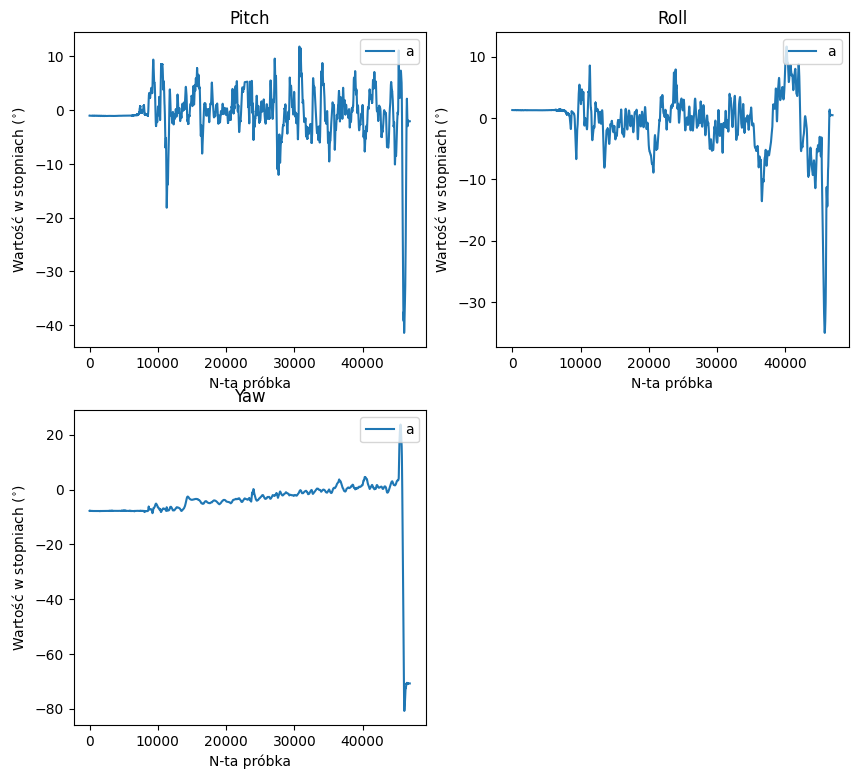

In [2]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time  = ur.readAttitude(ulog)
attitude_time = (attitude_time - attitude_time[0]) / 1e3

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])


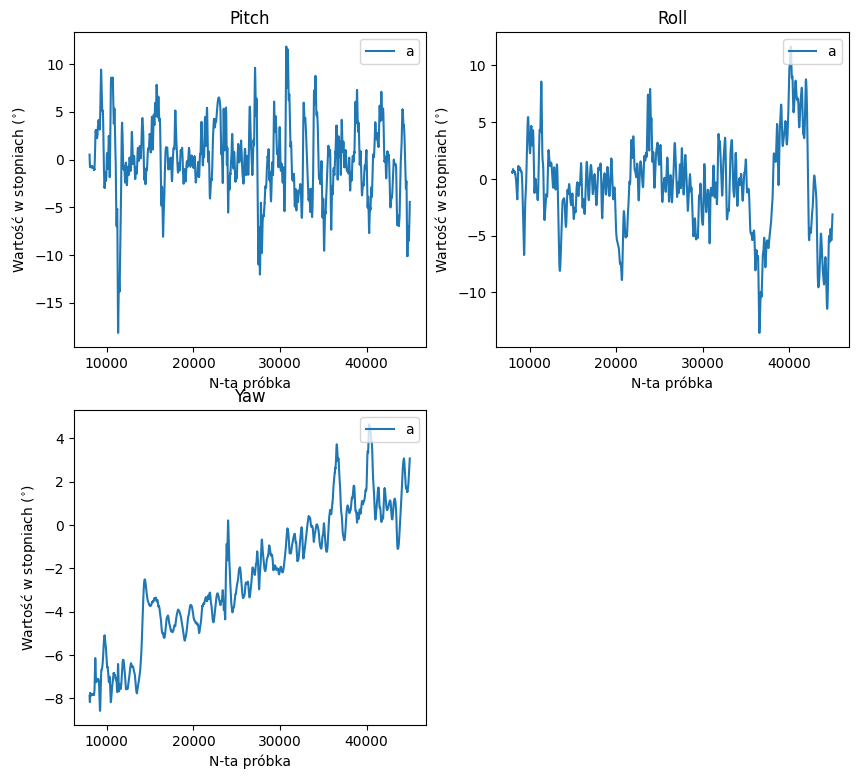

In [3]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
attitude_time = it_t

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])

### Metoda QLMS
---  

In [15]:
P_ORDER    = 5 
K_FORECAST = [1,3,7]
MU = 1e-3

x = np.copy(attitude)[::2]
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

w = qu.randQuaternionVector(P_ORDER)

for i in range(P_ORDER, x.shape[0]):
    for k, k_steps in enumerate(K_FORECAST):
        y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

    s = x[i-P_ORDER : i]
    e_priori = x[i] - np.sum(w * s).normalized()
    w = w + MU * (2 * e_priori * s.conjugate() -      # Update coefficients
                  s.conjugate() * e_priori.conjugate() )

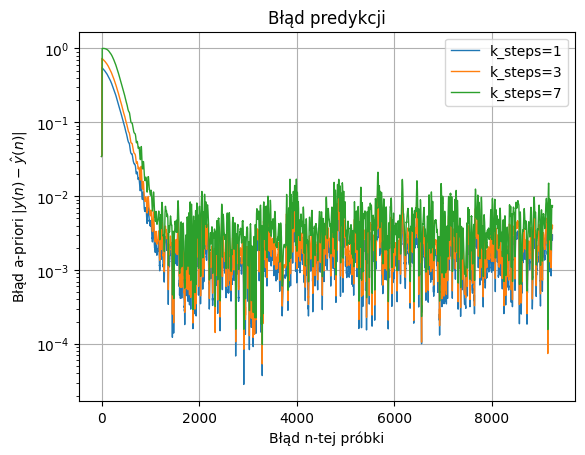

In [11]:
qv.displayPredictionError(x,y,K_FORECAST)